In [443]:
import numpy as np
import pandas as pd
from scipy.stats import circmean
from scipy.fftpack import rfft, irfft, fftfreq
from scipy.signal import freqz, lfilter, iirnotch, iirpeak, welch, csd, hilbert
from matplotlib import pyplot as plt

## Task 1: Filters and cleaning noise

### Section A

1

2

3

4

### Section B

In [500]:
var4students = np.load("data/var4students.npy", allow_pickle=True)
blank = var4students.item().get("blank")
stimulus = var4students.item().get("stimulus")

In [501]:
Fs = 100
T, N = blank.shape

time = time = 1000 * np.arange(T) / Fs

In [553]:
def find_stats(arr, keepdims=False):

    arr_mean = np.mean(arr, axis=1, keepdims=keepdims)
    arr_sem = np.std(arr, axis=1) / np.sqrt(arr.shape[1] - 1)

    return arr_mean, arr_sem

def plot_stats(time, arr_mean, arr_sem, label=""):

    plt.plot(time, arr_mean, label=label)
    plt.fill_between(time, arr_mean - arr_sem, arr_mean + arr_sem, alpha=0.5)

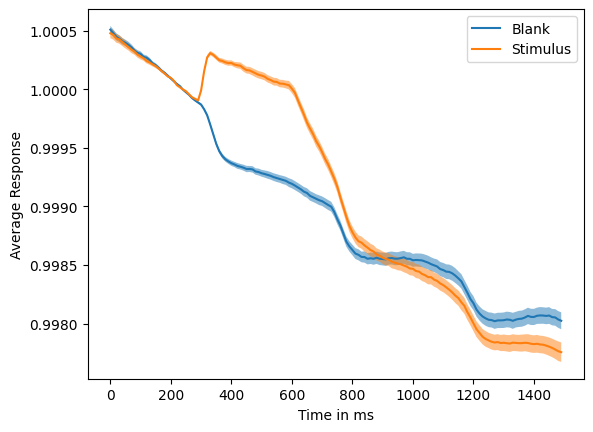

In [503]:
blank_mean, blank_sem = find_stats(blank)
stimulus_mean, stimulus_sem = find_stats(stimulus)

plot_stats(time, blank_mean, blank_sem, label="Blank")
plot_stats(time, stimulus_mean, stimulus_sem, label="Stimulus")

plt.xlabel("Time in ms") 
plt.ylabel("Average Response")
plt.legend(loc="upper right")

The frequencies bla bla are clearly shown 2.5 Hz

### Section C

In [372]:
freq = fftfreq(T, d=1 / Fs)

blank_power = np.apply_along_axis(rfft, 0, blank)
stimulus_power = np.apply_along_axis(rfft, 0, stimulus)

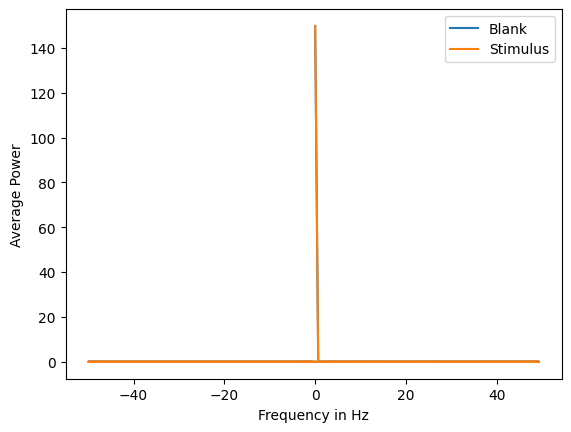

In [394]:
blank_power_mean, blank_power_sem = find_stats(blank_power)
stimulus_power_mean, stimulus_power_sem = find_stats(stimulus_power)

plot_stats(freq, blank_power_mean, blank_power_sem, label="Blank")
plot_stats(freq, stimulus_power_mean, stimulus_power_sem, label="Stimulus")

plt.xlabel("Frequency in Hz") 
plt.ylabel("Average Power")
plt.legend(loc="upper right")

In [497]:
f0 = 2.5
bandwidth = 0.1

b, a = iirnotch(f0, f0 / bandwidth, Fs)

impulse = np.zeros(T)
impulse[0] = 1

impulse_response = lfilter(b, a, impulse)

# Compute the frequency response
freq_range, freq_response = freqz(b, a, fs=Fs)

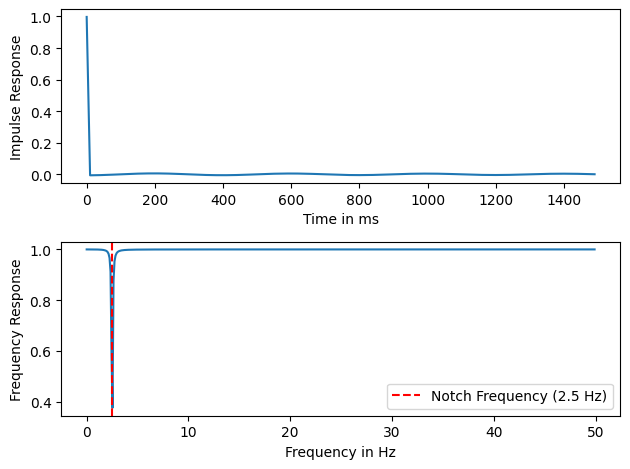

In [498]:
fig, axes = plt.subplots(2)

# Plot the impulse response
axes[0].plot(time, response)

axes[0].set_xlabel("Time in ms")
axes[0].set_ylabel("Impulse Response")

# Plot the frequency response
axes[1].plot(freq_range, freq_response)
axes[1].axvline(f0, color="r", linestyle="--", label=f"Notch Frequency ({f0} Hz)")

axes[1].set_xlabel("Frequency in Hz")
axes[1].set_ylabel("Frequency Response")
axes[1].legend()

plt.tight_layout()

IIR notch filter to remove single frequencies with bandwidth 0.1

In [437]:
def apply_filter(sig, freq, power, Fs, freq_range=[2, 5], bandwidth=0.1):
    
    range_idx = np.where((freq >= freq_range[0]) & (freq <= freq_range[1]), True, False)
    max_idx = np.argmax(power[range_idx, :], axis=0)
    
    heartbeat = freq[range_idx][max_idx]
    filtered_sig = np.zeros_like(sig)
    
    for i in range(heartbeat.size):
        
        b, a = iirnotch(heartbeat[i], heartbeat[i] / bandwidth, Fs)
        filtered_trial = lfilter(b, a, sig[:, i])
        filtered_sig[:, i] = filtered_trial

    return filtered_sig

In [440]:
filtered_blank = apply_filter(blank, freq, blank_power, Fs)
filtered_stimulus = apply_filter(stimulus, freq, stimulus_power, Fs)

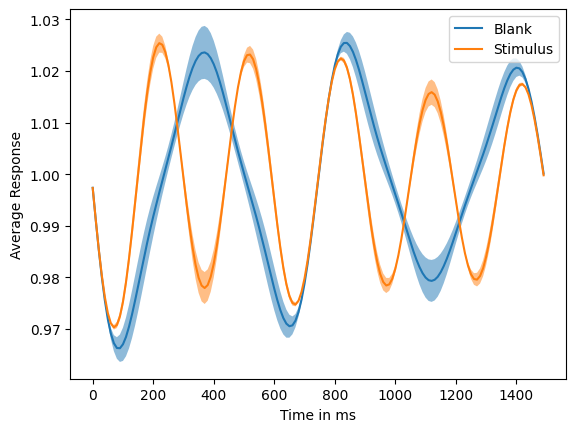

In [442]:
filtered_blank_mean, filtered_blank_sem = find_stats(filtered_blank)
filtered_stimulus_mean, filtered_stimulus_sem = find_stats(filtered_stimulus)

plot_stats(time, filtered_blank_mean, filtered_blank_sem, label="Blank")
plot_stats(time, filtered_stimulus_mean, filtered_stimulus_sem, label="Stimulus")

plt.xlabel("Time in ms") 
plt.ylabel("Average Response")
plt.legend(loc="upper right")

### Section D

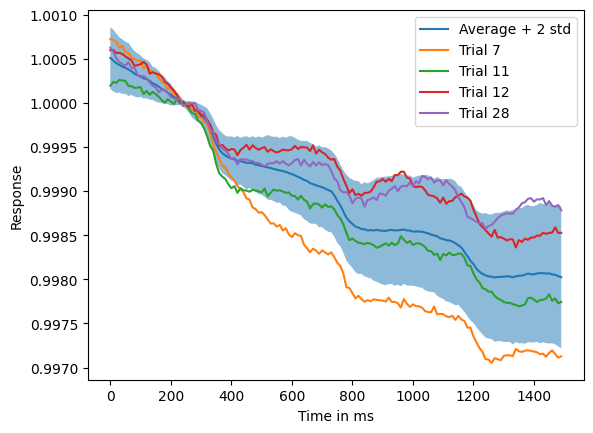

In [533]:
blank_std = np.std(blank, axis=1)
outliers = [7, 11, 12, 28]

plot_stats(time, blank_mean, 2 * blank_std, label='Average + 2 std')

for i in outliers:
    plt.plot(time, blank[:, i], label=f"Trial {i}")

plt.xlabel("Time in ms")
plt.ylabel("Response")
plt.legend()

In [556]:
tidy_blank = np.delete(blank, outliers, axis=1)

tidy_blank_mean, tidy_blank_sem = find_stats(tidy_blank, keepdims=True)

norm_stimulus = stimulus / tidy_blank_mean

norm_stimulus_mean, norm_stimulus_sem = find_stats(norm_stimulus)

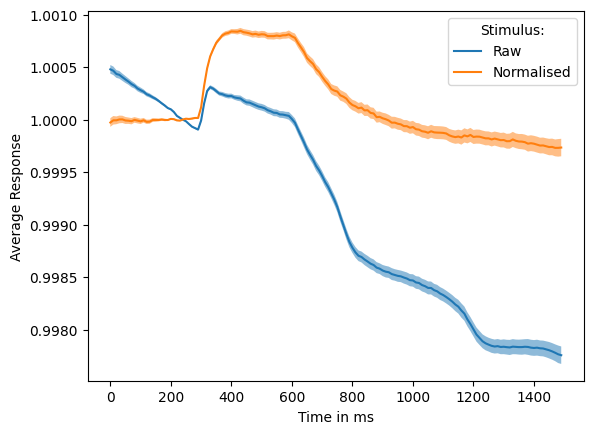

In [559]:
plot_stats(time, stimulus_mean, stimulus_sem, label="Raw")
plot_stats(time, norm_stimulus_mean, norm_stimulus_sem, label="Normalised")

plt.xlabel("Time in ms")
plt.ylabel("Average Response")
plt.legend(title="Stimulus:", loc="upper right")

### Section E

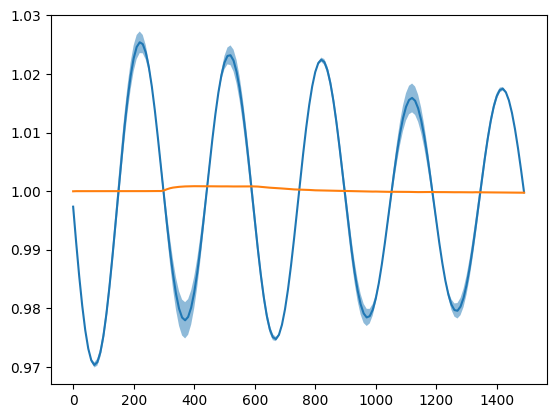

In [561]:
plot_stats(time, filtered_stimulus_mean, filtered_stimulus_sem, label="Filtered")
plot_stats(time, norm_stimulus_mean, norm_stimulus_sem, label="Normalised")

(0.0, 2.0)

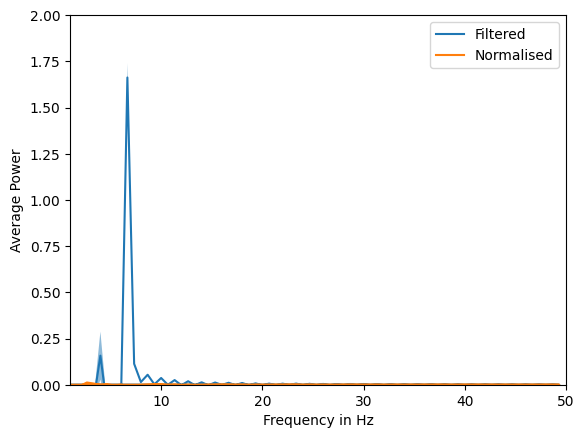

In [569]:
filtered_stimulus_power = np.apply_along_axis(rfft, 0, filtered_stimulus)
norm_stimulus_power = np.apply_along_axis(rfft, 0, norm_stimulus)

filtered_stimulus_power_mean, filtered_stimulus_power_sem = find_stats(filtered_stimulus_power)
norm_stimulus_power_mean, norm_stimulus_power_sem = find_stats(norm_stimulus_power)

plot_stats(freq, filtered_stimulus_power_mean, filtered_stimulus_power_sem, label="Filtered")
plot_stats(freq, norm_stimulus_power_mean, norm_stimulus_power_sem, label="Normalised")

plt.xlabel("Frequency in Hz") 
plt.ylabel("Average Power")
plt.legend(loc="upper right")

plt.xlim([1, 50])
plt.ylim([0, 2])

## Task 2: Fourier Transform

## Task 3: Filters

### Section A

In [262]:
filters = np.load("data/filters.npy", allow_pickle=True)
filtVec = filters.item().get("filtVec")
dataVec = filters.item().get("dataVec").flatten()

In [263]:
def apply_filter(x, f):
    
    y = np.zeros((f.shape[0], x.size))

    for n in range(x.size):
        for k in range(filtVec.shape[1]):
            y[:, n] += f[:, k] * x[n - k]

    return y

In [264]:
impulse = np.zeros(filtVec.shape[1])
impulse[0] = 1

response = apply_filter(impulse, filtVec)

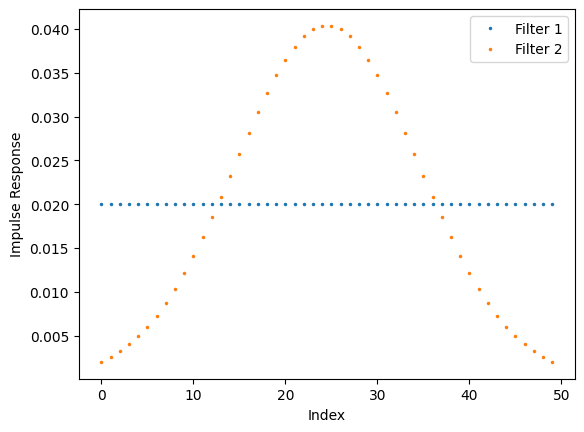

In [265]:
plt.plot(response.T, ".", markersize=3)

plt.xlabel("Index")
plt.ylabel("Impulse Response")
plt.legend(["Filter 1", "Filter 2"])

### Section B

In [266]:
y = apply_filter(dataVec, filtVec)

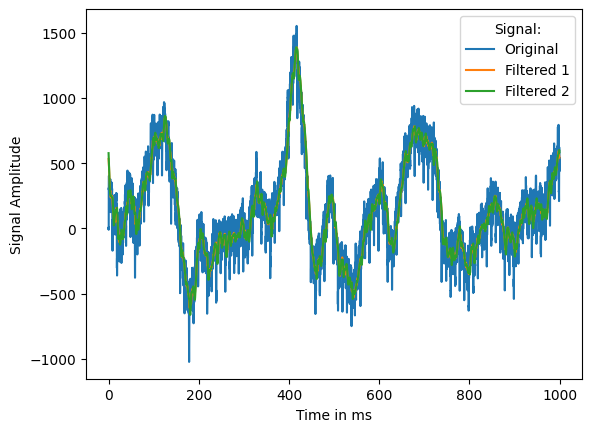

In [267]:
time = np.arange(dataVec.size) / 10
plt.plot(time, dataVec, linewidth=1.5)
plt.plot(time, y.T, linewidth=1.5)

plt.xlabel("Time in ms")
plt.ylabel("Signal Amplitude")
plt.legend(["Original", "Filtered 1", "Filtered 2"], title="Signal:")

### Section C

In [272]:
Fs = dataVec.size
T = 1

x = np.linspace(0, Fs * T, Fs)
xf = np.linspace(0, 1 / (2 * T), Fs // 2)

y0 = 2 / Fs * np.abs(fft(dataVec))[:Fs // 2]
yf = 2 / Fs * np.abs(fft(y))[:, :Fs // 2]

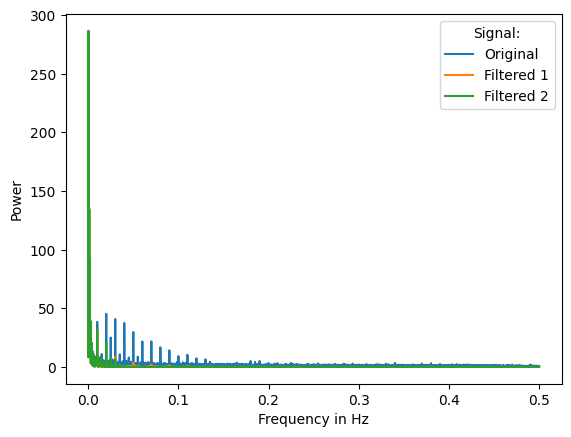

In [269]:
plt.plot(xf, y0)
plt.plot(xf, yf.T)

plt.xlabel("Frequency in Hz")
plt.ylabel("Power")
plt.legend(["Original", "Filtered 1", "Filtered 2"], title="Signal:")

Plotted only positive frequencies, resolution or frequency step is 1 / (2 * T) Hz, whereas max is Nyquist frequency Fs / 2 Hz.

### Section D

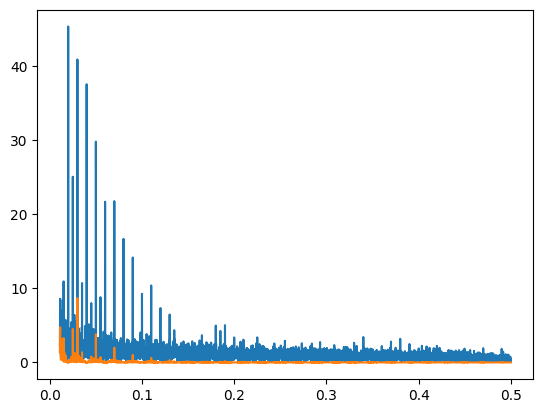

In [271]:
plt.plot(xf[110:], y0[110:])
plt.plot(xf[110:], yf[0, 110:].T)

Filter 1 is lowpass FIR with sharp descent and a lot of wripples. Filter 2 is lowpass FIR with gradual descent and few wripples.

### Section E

In [43]:
# cool that impulse response sums up to 1
np.sum(response, axis=1)

array([1., 1.])

Compared to ideal filter, filter 1 has lots of wripples due to sharp descent, whereas filter 2 does not have wripples but is not able to preserve original frequencies within the band because of very gradual ascent and descent.

## Task 4: PSD and Coherence

### Section A and B

In [219]:
coherence = np.load("data/coherence.npy", allow_pickle=True)
fwrsig_nospikes = coherence.item().get("fwrsig_nospikes").flatten()
st = coherence.item().get("st").toarray().flatten()

In [220]:
Fs = 24038

freq, fwr_power = welch(fwrsig_nospikes, Fs, noverlap=0, nperseg=2 * Fs)
freq, st_power = welch(st, Fs, noverlap=0, nperseg=2 * Fs)

fwr_power = fwr_power.flatten()
st_power = st_power.flatten()

In [221]:
min_freq, max_freq = 3, 70
idx = np.where((freq >= min_freq) & (freq <= max_freq))

norm_fwr_power = fwr_power[idx] / np.sum(fwr_power[idx])
norm_st_power = st_power[idx] / np.sum(st_power[idx])

In [222]:
fwr_mean = np.mean(norm_fwr_power)
fwr_std = np.std(norm_fwr_power)

st_mean = np.mean(norm_st_power)
st_std = np.std(norm_st_power)

fwr_threshold = fwr_mean + 5 * fwr_std
st_threshold = st_mean + 5 * st_std

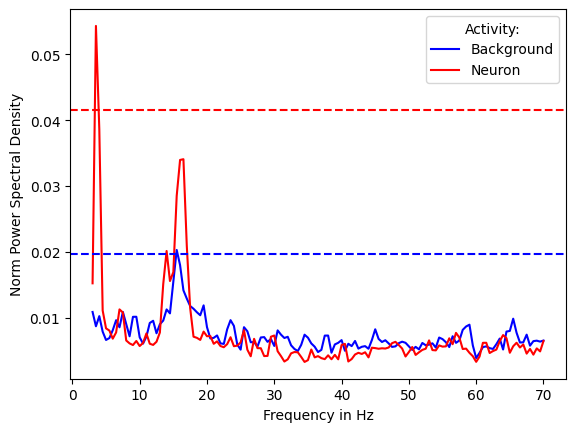

In [223]:
plt.plot(freq[idx], norm_fwr_power, label="Background", c="b")
plt.plot(freq[idx], norm_st_power, label="Neuron", c="r")

plt.axhline(y=fwr_threshold, linestyle="--", c="b")
plt.axhline(y=st_threshold, linestyle="--", c="r")

plt.xlabel("Frequency in Hz")
plt.ylabel("Norm Power Spectral Density")
plt.legend(title="Activity:")

In [224]:
fwr_keep = freq[idx][norm_fwr_power > fwr_threshold]
st_keep = freq[idx][norm_st_power > st_threshold]

print("Principal Oscillation Frequency:")
print(f"fwr: {fwr_keep[0]} Hz")
print(f"st: {st_keep[0]} Hz")

Principal Oscillation Frequency:
fwr: 15.5 Hz
st: 3.5 Hz


### Section C

In [225]:
freq, cross_spectrum = csd(fwrsig_nospikes, st, Fs, noverlap=0, nperseg=2 * Fs)
cross_spectrum = cross_spectrum[idx]

Text(0, 0.5, 'Cross Spectral Density')

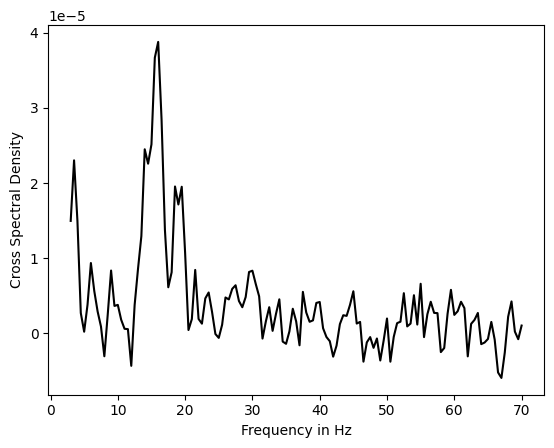

In [226]:
plt.plot(freq[idx], cross_spectrum, label="Background", c="k")

plt.xlabel("Frequency in Hz")
plt.ylabel("Cross Spectral Density")

### Section D

In [227]:
coherence = np.abs(cross_spectrum)**2 / (fwr_power[idx] * st_power[idx])

Text(0, 0.5, 'Coherence')

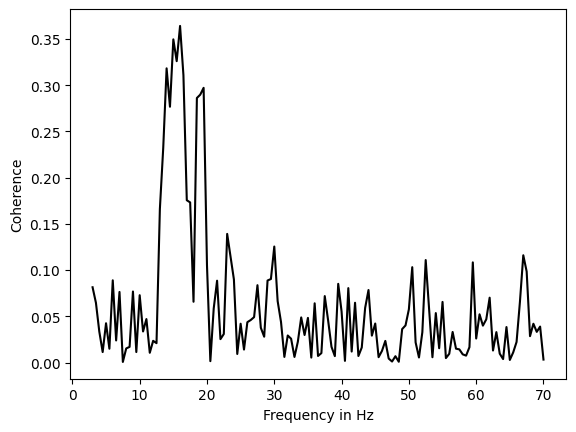

In [228]:
plt.plot(freq[idx], coherence, c="k")

plt.xlabel("Frequency in Hz")
plt.ylabel("Coherence")

### Section E

In [229]:
freq_res = 0.25

fwr_freq = fftfreq(fwrsig_nospikes.size, d=1 / Fs)
st_freq = fftfreq(st.size, d=1 / Fs)

fwr_fsig = rfft(fwrsig_nospikes)
st_fsig = rfft(st)

fwr_fsig[(fwr_freq < fwr_keep - freq_res) | (fwr_freq > fwr_keep + freq_res)] = 0
st_fsig[(st_freq < st_keep - freq_res) | (st_freq > st_keep + freq_res)] = 0

filtered_fwr = irfft(fwr_fsig)
filtered_st = irfft(st_fsig)

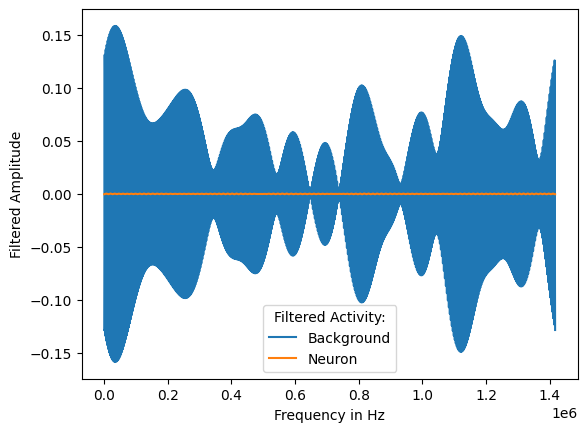

In [248]:
plt.plot(filtered_fwr, label="Background")
plt.plot(filtered_st, label="Neuron")

plt.xlabel("Frequency in Hz")
plt.ylabel("Filtered Amplitude")
plt.legend(title="Filtered Activity:")

In [247]:
analytic_fwr = hilbert(filtered_fwr)
spike_background = analytic_fwr[st == 1]

amplitude_envelope = np.abs(spike_background)
phase = np.angle(spike_background)

phase_mean = np.rad2deg(circmean(phase, low=phase.min(), high=phase.max()))

print(f"Most exciting phase computed by circular mean: {phase_mean:.3g}°")

Most exciting phase computed by circular mean: -72.5°


Text(0.5, 1.0, 'Phase of Background Activity upon Spike')

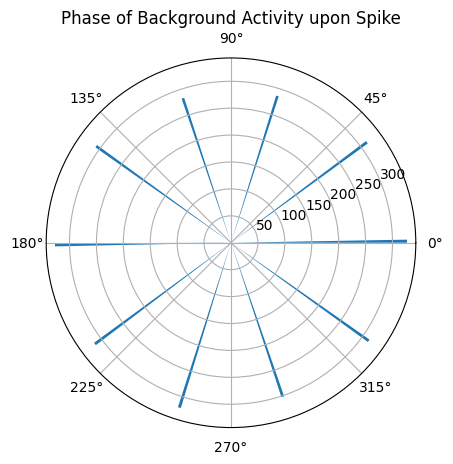

In [242]:
ax = plt.subplot(polar=True)

ax.hist(phase, width=np.deg2rad(1))

ax.set_title("Phase of Background Activity upon Spike")

### Section F

Describe differences, pluses and cons of coherence and phase locking.